In [ ]:
%pip install -r requirements.txt

# Music Video Generator

Welcome to the Music Video Generator

This tool uses FFT and other Tools for the Generation of a Music Video

In [6]:
import json
import os

# File path for the audio file
audio_file_path = "F:/Audio/Ableton/#OUTTHERE/Game/deserve.mp3"

# Topic and art style
topic = "Deserve of Love"
artstyle = (
    " "
    " "
)

# Audio processing configuration
audio_config = {
    "sample_rate": 22050,  # in Hz
    "beats_per_bar": 16,
    "offset": 0.2,  # in seconds
    "threshold": 0.3,  # in decimal
    "detail": 6,  # decimal places
    "max_repetition": 2,  # in bars
}

# Script prompts and examples
script_prompts = {
    'INSTRUCTION': '[INSTRUCTION]',
    'BASE_PROMPT': 'Write a music video script based on the following track information.',
    'DIRECTOR_PROMPT': 'Act as a director and create a script for a music video based on the given track information.',
    'GOAL_PROMPT': 'Write an interesting and engaging script.',
    'OUTPUT_FORMAT_PROMPT': 'Output a JSON array of scenes in the following format:',
    'TOPIC_GUIDANCE_PROMPT': 'Use the following track information as guidance and follow the instructions below:',
    
    'EXAMPLE_SCENE': {
        "script": {
            "title": "...",  # title of the script
            "description": "...",  # one sentence description (up to 20 words)
        },
        "scenes": [
            {
                "scene_id": 0,  # unique scene id
                "scene_title": "...",  # title of the scene
                "scene_description": "...",  # one sentence description (up to 20 words)
                "scene_tags": ["...", "...", "..."],  # tags of the scene (up to 20 tags)
                "scene_color": "#...",  # fitting color in hex format
            },
            # Additional scenes can be added here
        ]
    }
}

# Full configuration set (including prompts, processing, and other data)
config = {
    "audio_file_path": audio_file_path,
    "topic": topic,
    "artstyle": artstyle,
    "audio_config": audio_config,
    "script_prompts": script_prompts,
}

# Function to save the config as a JSON file
def save_config(file_path='music_video_config.json'):
    with open(file_path, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Configuration saved to {file_path}")

# Function to load the config from a JSON file
def load_config(file_path='music_video_config.json'):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            loaded_config = json.load(f)
        print(f"Configuration loaded from {file_path}")
        return loaded_config
    else:
        save_config(file_path)  # Save the default config if not exists
        return config

Track file path: F:/Audio/Ableton/#OUTTHERE/Game/deserve.mp3
Track Information:
topic: Deserve of Love
key: D minor
size_in_mb: 8.273874
bpm: 167
sample_rate_in_hz: 22050
duration_in_minutes: 1.807456
chunk_size: [63377]
beats_per_bar: 16
artstyle:   



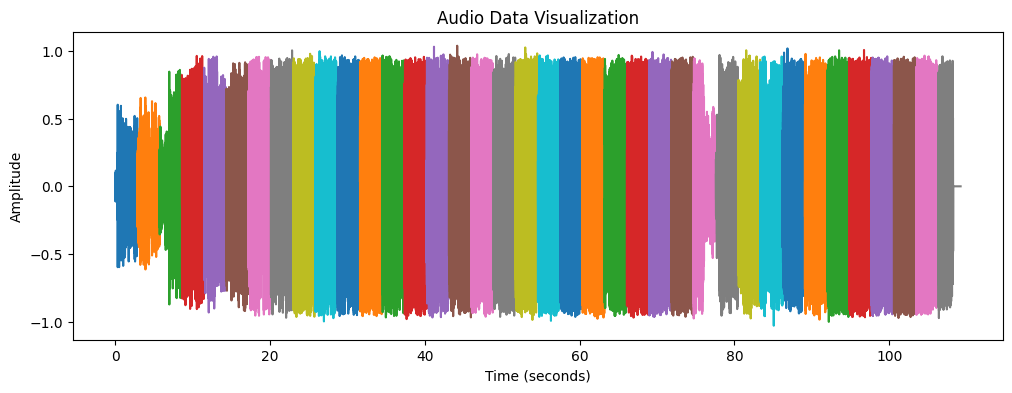

In [7]:
import librosa
import matplotlib.pyplot as plt
import os
import mutagen
import numpy as np
import math

def get_duration(y, sr):
    duration_in_seconds = librosa.get_duration(y=y, sr=sr)
    duration_in_minutes = duration_in_seconds / 60
    # get rounded duration
    duration_in_minutes = round(duration_in_minutes, detail)
    return duration_in_minutes

def get_bpm(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)[0]
    # get round up
    tempo = round(tempo, detail)
    return 167

def get_key(y, sr):
    return "D minor"

def get_file_size(file_path):
    try:
        file_size = os.path.getsize(file_path)
        # get rounded file size
        file_size = round(file_size / 1024 / 1024, detail)
        return file_size
    except Exception as e:
        print(f"Error getting file size: {str(e)}")
        return None

def get_track_metadata(track_file_path):
    try:
        audio = mutagen.File(track_file_path, easy=True)
        if audio is not None:
            return audio
        else:
            return None
    except Exception as e:
        print(f"Error reading track metadata: {str(e)}")
        return None
    
def extract_chunk_size(bpm, sr, beats_per_bar=32):
    seconds_per_minute = 60
    samples_per_beat = sr * seconds_per_minute / bpm
    samples_per_bar = samples_per_beat * beats_per_bar
    divisible_chunk_size = int(samples_per_bar / 2)

    return divisible_chunk_size

def fill_missing_data(metadata, audio_data, sr, track_file_path, topic="", beats_per_bar=32, artstyle=""):
    try:
        # Check if metadata is a dictionary
        if not isinstance(metadata, dict):
            metadata = {}

        # Set each field
        key = get_key(audio_data, sr)
        if isinstance(topic, str):
            metadata['topic'] = topic
        metadata['key'] = key if isinstance(key, str) else "Unknown"
        metadata['size_in_mb'] = get_file_size(track_file_path)
        metadata['bpm'] = get_bpm(audio_data, sr)
        metadata['sample_rate_in_hz'] = sr
        metadata['duration_in_minutes'] = get_duration(audio_data, sr)
        metadata['chunk_size'] = [extract_chunk_size(get_bpm(audio_data, sr), sr, beats_per_bar)]
        metadata['beats_per_bar'] = beats_per_bar
        metadata['artstyle'] = artstyle
        return metadata
    except Exception as e:
        print(f"Error filling missing data: {str(e)}")
        return None

    
def gather_track_information(audio_data, sr, track_file_path, topic="", beats_per_bar=32, artstyle=""):
    info = "Track Information:\n"
    metadata = None

    try:
        metadata = fill_missing_data(get_track_metadata(track_file_path), audio_data, sr, track_file_path, topic, beats_per_bar, artstyle)
        if metadata is None:
            info += "Failed to read track metadata.\n"
            return info, metadata

        for key, value in metadata.items():
            info += f"{key}: {value}\n"

    except Exception as e:
        info += f"Error processing track: {str(e)}"

    return info, metadata

# Function to split audio file into chunks with an offset
def split_audio_file(y, chunk_size):
    audio_chunks = []

    for i in range(0, len(y), chunk_size):
        chunk = y[i:i + chunk_size]
        if len(chunk) < chunk_size:
            chunk = np.pad(chunk, (0, chunk_size - len(chunk)), mode='constant')
        audio_chunks.append(chunk)

    return audio_chunks

# Function to visualize the audio data with scene lengths and an offset
def visualize_audio_data(audio_data, sample_rate, chunk_size):
    num_chunks = len(audio_data)
    total_duration = len(audio_data) * chunk_size / sample_rate

    # Calculate scene lengths based on the chunk size
    scene_lengths = [chunk_size / sample_rate] * num_chunks

    # Recalculate colors based on the number of scenes
    num_scenes = int(math.ceil(total_duration / scene_lengths[0]))
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(num_scenes)]

    # Plot each segment of audio data with a different color and display scene lengths
    plt.figure(figsize=(12, 4))
    plt.title('Audio Data Visualization')
    for i, chunk in enumerate(audio_data):
        x = np.arange(i * chunk_size, (i + 1) * chunk_size) / sample_rate
        scene_index = int(i * chunk_size / (scene_lengths[0] * sample_rate))
        plt.plot(x, chunk, color=colors[scene_index % len(colors)])  # Use modulo operator to loop over colors

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

# Generate the story and plot the scene features
print("Track file path:", audio_file_path)
t_y, t_sr = librosa.load(audio_file_path, sr=sr, mono=True)

# cut 50% from t_y

t_y = t_y[:int(len(t_y)/2)]


track_info, t_metadata = gather_track_information(t_y, t_sr, audio_file_path, topic, beats_per_bar, artstyle)
t_chunk_size = t_metadata['chunk_size'][0]

# Calculate the offset in samples
offset_samples = int(offset * t_sr)

# Apply the offset to the audio data
t_offset_audio = t_y[offset_samples:]

# Split the offset audio into chunks
t_splited_audio = split_audio_file(np.array(t_offset_audio), t_chunk_size)

print(track_info)
visualize_audio_data(t_splited_audio, t_sr, t_chunk_size)


c:\Users\robin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=991
  warnings.warn(


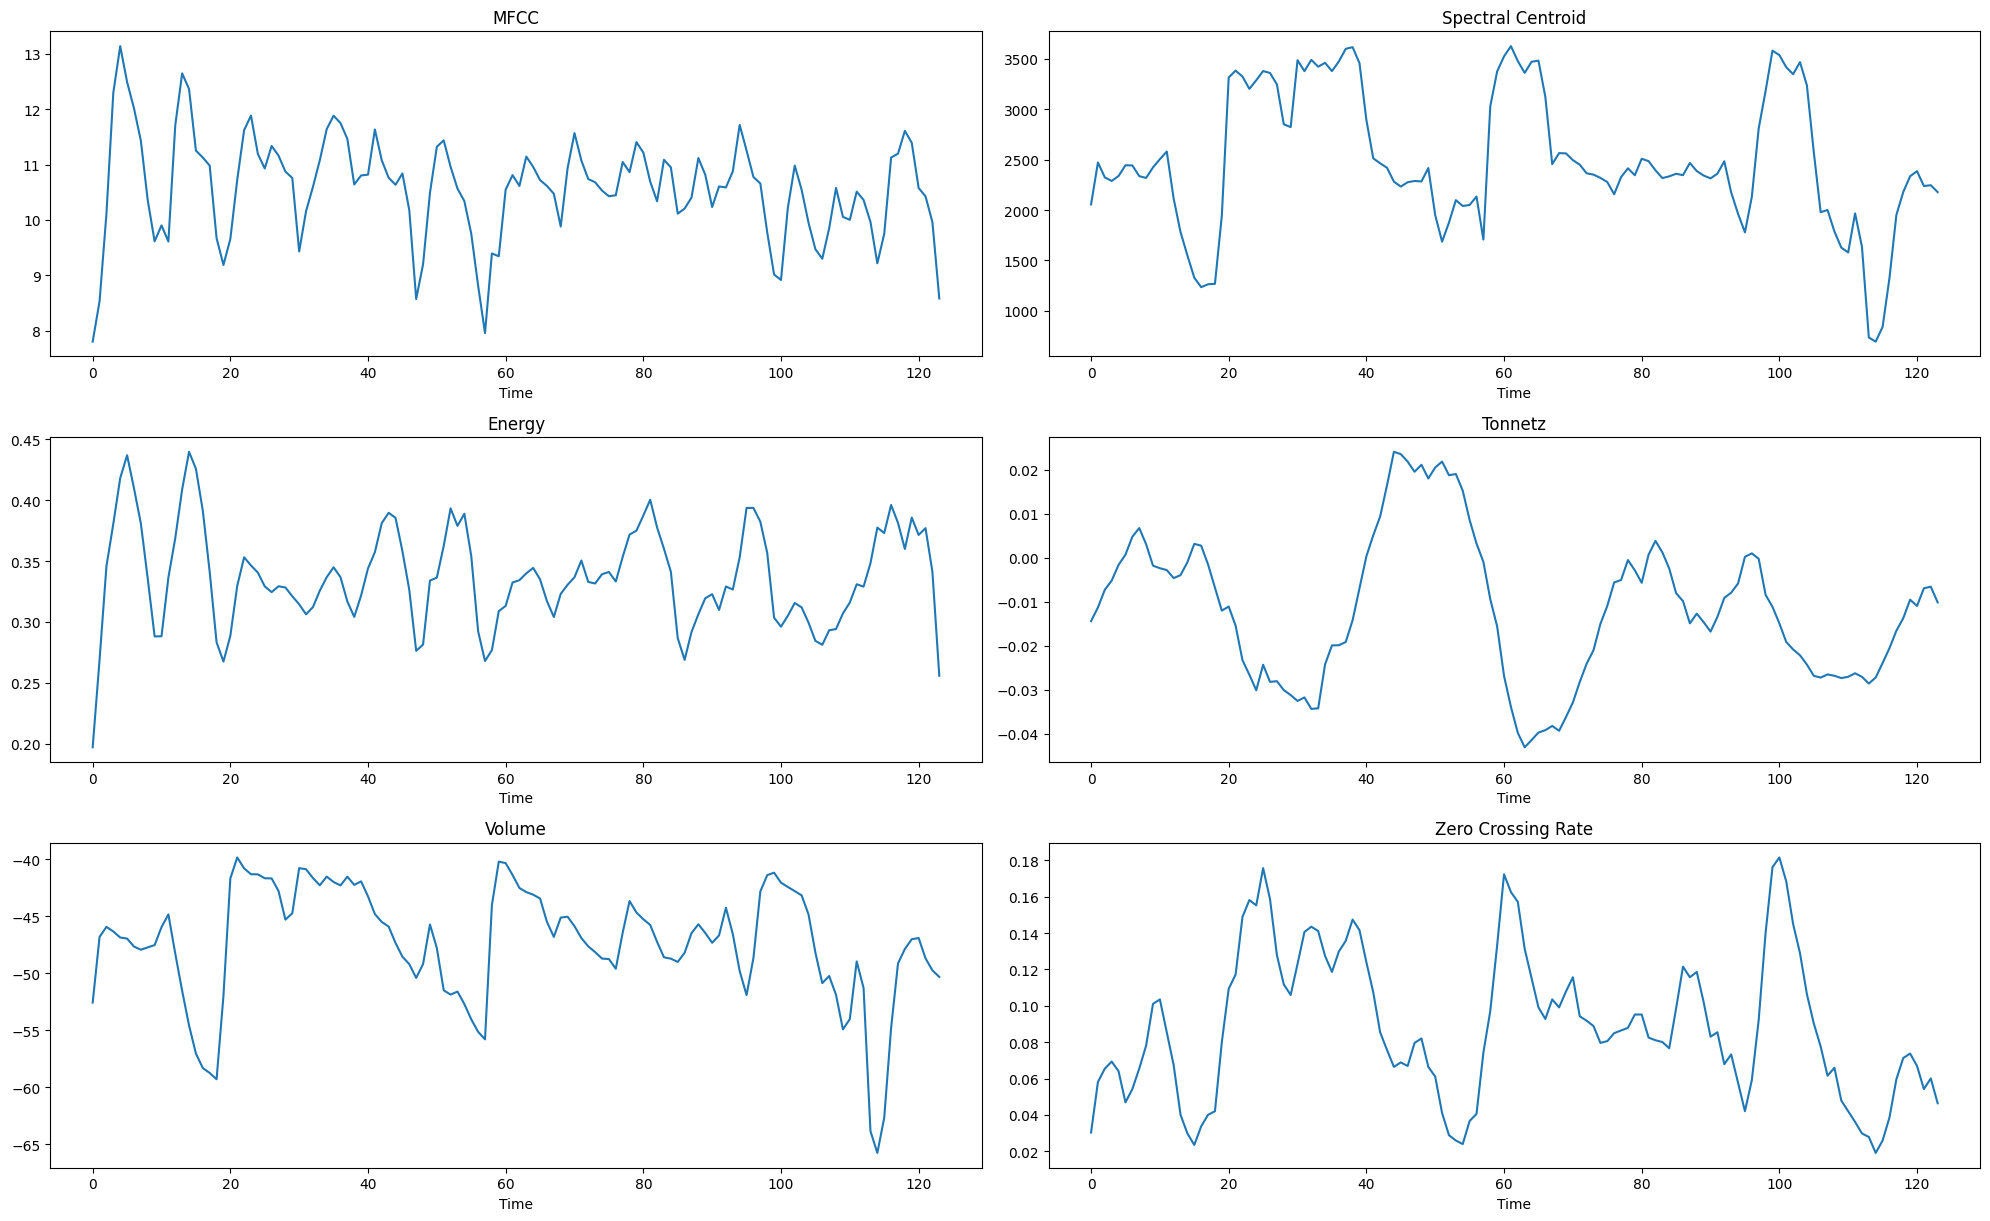

In [8]:
# Function to analyze a music snippet and return features
def analyze_music(music_snippet, sr):
    features = {}
    
    def volume(y):
        scene_mono = librosa.to_mono(y)
        S = np.abs(librosa.stft(scene_mono))
        loudness = librosa.amplitude_to_db(S, ref=np.max)

        return np.array(loudness)

    # Map each feature name to its corresponding librosa function
    feature_functions = {
        "MFCC": librosa.feature.mfcc,
        "Spectral Centroid": librosa.feature.spectral_centroid,
        "Energy": librosa.feature.rms,
        "Tonnetz": librosa.feature.tonnetz,
        "Volume": volume,
        "Zero Crossing Rate": librosa.feature.zero_crossing_rate,
    }
    
    for feature_name, feature_function in feature_functions.items():
        if feature_name in ["Zero Crossing Rate", "Energy", "Volume"]:
            feature = feature_function(y=music_snippet)
        else:
            feature = feature_function(y=music_snippet, sr=sr)
        features[feature_name] = feature
    
    return features

# Function to visualize the features
def visualize_features(features):
    plt.figure(figsize=(20, 20))

    for i, (feature_name, feature) in enumerate(features.items()):
        plt.subplot(5, 2, i+1)

        if len(feature.shape) > 1:
            time = range(feature.shape[1])
            plt.plot(time, np.mean(feature, axis=0))
        else:
            time = range(len(feature))
            plt.plot(time, feature)

        plt.title(feature_name)
        plt.xlabel('Time')
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

# Make a list of all the features
def get_features(audio_data, sr):
    features = []
    for i, chunk in enumerate(audio_data):
        features_chunk = analyze_music(chunk, sr)
        features.append(features_chunk)
    return features

# Example usage:
t_audio_features = analyze_music(t_splited_audio[12], t_sr)
visualize_features(t_audio_features)
t_features = get_features(t_splited_audio, t_sr)

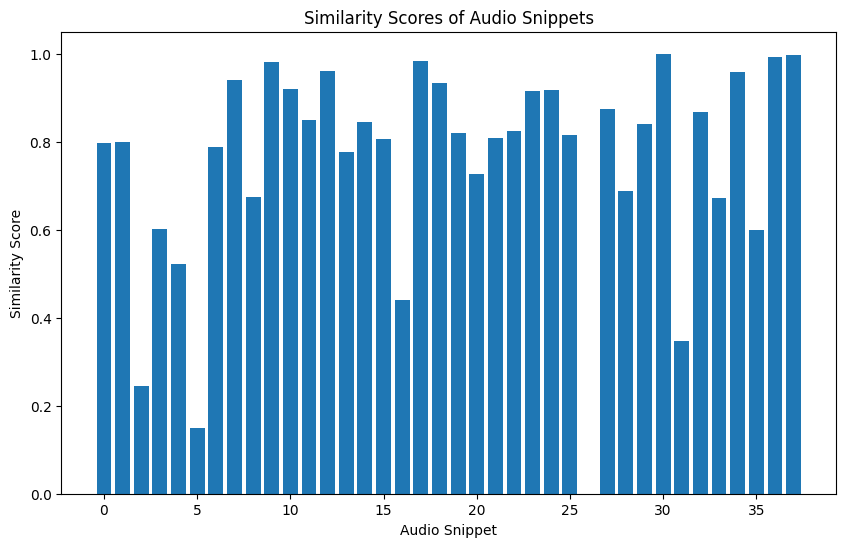

In [9]:
# Function to calculate the similarity between two audio snippets

from sklearn.preprocessing import MinMaxScaler, minmax_scale

def find_similar_audio_snippets(audio_snippets, audio_features):
    similar_audio_snippets = []

    if not audio_features:
        return similar_audio_snippets

    max_feature_length = max(
        feature.shape[1]
        for features in audio_features
        for feature in features.values()
        if isinstance(feature, np.ndarray)
    )

    for audio_snippet in audio_snippets:
        similarity_scores = []

        snippet_mean = np.mean(audio_snippet)

        for features in audio_features:
            max_similarity = 0

            for feature_name, audio_feature in features.items():
                if not isinstance(audio_feature, np.ndarray):
                    continue

                feature_length = audio_feature.shape[1]

                if feature_length < max_feature_length:
                    audio_feature = np.pad(
                        audio_feature,
                        [(0, 0), (0, max_feature_length - feature_length)],
                        mode="constant",
                    )

                feature_mean = np.mean(audio_feature)
                similarity = 1 - np.abs(snippet_mean - feature_mean)  # Using distance measure

                if similarity > max_similarity:
                    max_similarity = similarity

            similarity_scores.append(max_similarity)

        similar_audio_snippets.append(max(similarity_scores))

    # Normalize positive and negative similarity scores separately
    positive_scores = [score for score in similar_audio_snippets if score > 0]
    negative_scores = [score for score in similar_audio_snippets if score <= 0]

    # Normalize positive scores if the list is not empty
    if positive_scores:
        normalized_positive = minmax_scale(positive_scores, feature_range=(0, 1))
    else:
        normalized_positive = np.array([])

    # Normalize negative scores if the list is not empty
    if negative_scores:
        normalized_negative = minmax_scale(negative_scores, feature_range=(-1, 0))
    else:
        normalized_negative = np.array([])

    # Combine the normalized scores
    normalized_scores = np.concatenate((normalized_positive, normalized_negative))

    return normalized_scores


def visualize_similarity_scores(similarity_scores):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(similarity_scores)), similarity_scores)
    plt.xlabel('Audio Snippet')
    plt.ylabel('Similarity Score')
    plt.title('Similarity Scores of Audio Snippets')
    plt.show()

# Example usage:
t_similarity_scores = find_similar_audio_snippets(t_splited_audio, t_features)
visualize_similarity_scores(t_similarity_scores)



Number of scenes: 23
Shape of the scenes: [2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1]


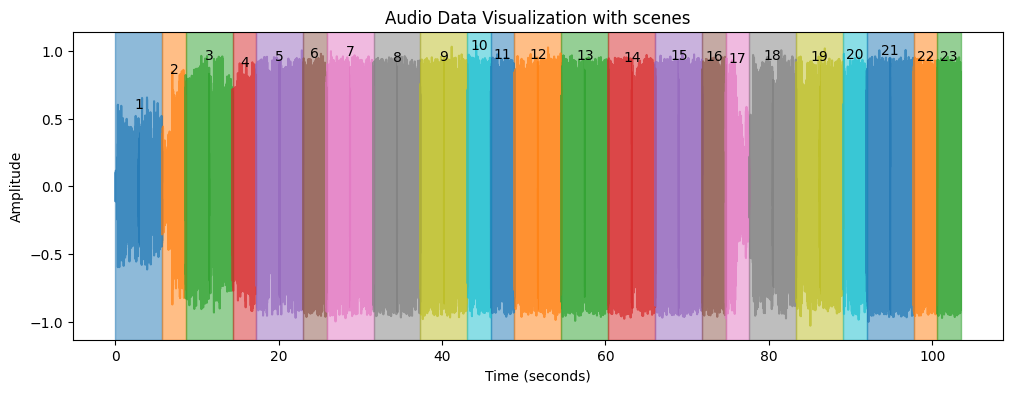

In [10]:
# Function to generate scenes based on similarity scores and audio data
def generate_scenes(similarity_scores, audio_data, threshold, max_repetition):
    scenes = []
    scene = []
    last_similarity_score = similarity_scores[0]

    for i, similarity_score in enumerate(similarity_scores):

        if abs(similarity_score - last_similarity_score) > threshold or len(scene) >= max_repetition:
            scenes.append(np.asarray(scene))
            scene = []
            scene.append(audio_data[i])
        else:
            scene.append(audio_data[i])

        last_similarity_score = similarity_score

    return scenes

# Function to visualize the audio data with scene lengths
def visualize_scenes(scenes, sr, chunk_size):
    num_scenes = len(scenes)
    total_duration = sum(len(scene) for scene in scenes) * chunk_size / sr

    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(num_scenes)]

    plt.figure(figsize=(12, 4))
    plt.title('Audio Data Visualization with scenes')

    offset = 0  # Initialize offset
    for i, scene in enumerate(scenes):
        scene_duration = len(scene) * chunk_size / sr
        for audio_data in scene:
            # Create the x array
            x = np.arange(len(audio_data)) / sr + offset
            # Plot the original audio data
            plt.plot(x, audio_data, color=colors[i], alpha=0.7)

            part_duration = len(audio_data) / sr
            offset += part_duration  # Update offset after each part

        plt.axvspan(offset - scene_duration, offset, color=colors[i], alpha=0.5)
        plt.text((offset - scene_duration + offset) / 2, np.max(scene[0]), f"{i+1}", color='black', ha='center', va='center')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

t_scenes = generate_scenes(t_similarity_scores, t_splited_audio, threshold, max_repetition)
t_scenes_len_mapped = list(map(lambda x: len(x), t_scenes))
t_metadata['scenes'] = t_scenes_len_mapped
print("Number of scenes:", len(t_scenes))
print("Shape of the scenes:", [len(scene) for scene in t_scenes])
visualize_scenes(t_scenes, t_sr, t_chunk_size)

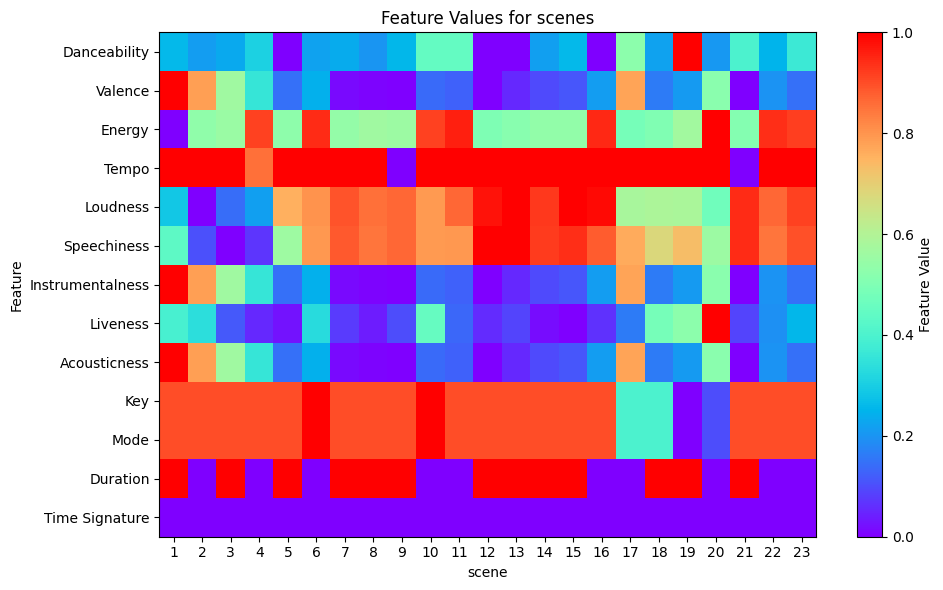

In [11]:
# Function to compute danceability feature for all scenes
def compute_danceability(scenes, sr):
    # Custom implementation to compute danceability feature for all scenes
    danceability_scores = []

    for scene in scenes:
        # Perform onset detection on the scene
        scene_mono = librosa.to_mono(scene)
        onset_env = librosa.onset.onset_strength(y=scene_mono, sr=sr)

        # Perform beat tracking using the onset strength
        tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

        # Compute the rhythm stability
        rhythm_stability = compute_rhythm_stability(beat_frames)

        # Compute the overall regularity
        beat_strength = librosa.feature.rms(y=scene, frame_length=2048, hop_length=512)
        overall_regularity = compute_overall_regularity(tempo, beat_strength)

        # Calculate danceability based on rhythm stability and overall regularity
        danceability = (rhythm_stability + overall_regularity) / 2.0
        danceability_scores.append(danceability)

    return np.array(danceability_scores)


def compute_rhythm_stability(beat_frames):
    # Calculate the temporal variations between adjacent beat frames
    beat_intervals = np.diff(beat_frames)

    # Calculate the standard deviation of beat intervals
    rhythm_stability = np.std(beat_intervals)

    return rhythm_stability


def compute_overall_regularity(tempo, beat_strength):
    # Calculate the variations in beat strength values
    beat_strength_variations = np.diff(beat_strength)

    # Calculate the overall regularity based on the standard deviation of beat strength variations
    overall_regularity = np.std(beat_strength_variations)

    return overall_regularity

# Function to compute valence scores for all scenes
def compute_valence(scenes, sr):
    valence_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        spectral_contrast = librosa.feature.spectral_contrast(y=scene_mono, sr=sr)
        valence = np.mean(spectral_contrast)
        valence_scores.append(valence)

    return np.array(valence_scores)

# Function to compute energy scores for all scenes
def compute_energy(scenes, _sr):
    energy_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        rms_energy = librosa.feature.rms(y=scene_mono)
        energy = np.mean(rms_energy)
        energy_scores.append(energy)

    return np.array(energy_scores)

# Function to compute tempo for each scene
def compute_tempo(scenes, sr):
    tempo_values = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        tempo, _ = librosa.beat.beat_track(y=scene_mono, sr=sr)
        tempo_values.append(tempo)

    return np.array(tempo_values)

# Function to compute the loudness of each scene
def compute_loudness(scenes, _sr):
    loudness_values = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        S = np.abs(librosa.stft(scene_mono))
        loudness = librosa.amplitude_to_db(S, ref=np.max)
        loudness_values.append(np.mean(loudness))

    return np.array(loudness_values)

# Function to compute speechiness scores for all scenes
def compute_speechiness(scenes, _sr):
    speechiness_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        spectral_centroid = librosa.feature.spectral_centroid(y=scene_mono)
        speechiness = np.mean(spectral_centroid)
        speechiness_scores.append(speechiness)

    return np.array(speechiness_scores)

# Function to compute the spectral flatness
def compute_instrumentalness(scenes, _sr):
    instrumentalness_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        spectral_contrast = librosa.feature.spectral_contrast(y=scene_mono)
        instrumentalness = np.mean(spectral_contrast)
        instrumentalness_scores.append(instrumentalness)

    return np.array(instrumentalness_scores)
# Function to compute the liveness feature
def compute_liveness(scenes, _sr):
    liveness_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        onset_strength = librosa.onset.onset_strength(y=scene_mono)
        liveness = np.mean(onset_strength)
        liveness_scores.append(liveness)

    return np.array(liveness_scores)

# Function to compute the spectral flatness
def compute_acousticness(scenes, _sr):
    acousticness_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        spectral_contrast = librosa.feature.spectral_contrast(y=scene_mono)
        acousticness = np.mean(spectral_contrast)
        acousticness_scores.append(acousticness)

    return np.array(acousticness_scores)

# Function to compute the key of each scene
def compute_key(scenes, _sr):
    key_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        chroma = librosa.feature.chroma_stft(y=scene_mono)
        key = np.argmax(np.mean(chroma, axis=1))
        key_scores.append(key)

    return np.array(key_scores)

# Function to compute the mode of each scene
def compute_mode(scenes, _sr):
    mode_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        chroma = librosa.feature.chroma_stft(y=scene_mono)
        mode = np.argmax(np.mean(chroma, axis=1))
        mode_scores.append(mode)

    return np.array(mode_scores)

# Function to compute the duration of each scene
def compute_duration(scenes, sr):
    duration_scores = []

    for scene in scenes:
        duration = len(scene) / sr
        duration_scores.append(duration)

    return np.array(duration_scores)

# Function to compute the time signature of each scene
def compute_time_signature(scenes, _sr):
    time_signature_scores = []

    for scene in scenes:
        scene_mono = librosa.to_mono(scene)
        tempo = librosa.feature.rhythm.tempo(y=scene_mono)
        time_signature = 4 if tempo % 4 == 0 else 3
        time_signature_scores.append(time_signature)

    return np.array(time_signature_scores)

# Define the features and their computation functions
feature_dict = {
    'Danceability': compute_danceability,
    'Valence': compute_valence,
    'Energy': compute_energy,
    'Tempo': compute_tempo,
    'Loudness': compute_loudness,
    'Speechiness': compute_speechiness,
    'Instrumentalness': compute_instrumentalness,
    'Liveness': compute_liveness,
    'Acousticness': compute_acousticness,
    'Key': compute_key,
    'Mode': compute_mode,
    'Duration': compute_duration,
    'Time Signature': compute_time_signature
}

# Compute the selected features
features = []
for feature_name in feature_dict.keys():
    if feature_name in feature_dict:
        computation_function = feature_dict[feature_name]
        feature_value = computation_function(t_scenes, t_sr)
        features.append(feature_value)
    else:
        print(f"Warning: Feature '{feature_name}' not found.")

def generate_scene_features(feature_names, scene_features):
    num_scenes = len(scene_features[0])  # Assuming all features have the same number of scenes

    scene_features_list = []

    for i in range(num_scenes):
        scene_feature_dict = {"scene": i + 1}

        for name, feature_values in zip(feature_names, scene_features):
            scaler = MinMaxScaler()
            scaled_values = scaler.fit_transform(feature_values.reshape(-1, 1)).flatten()
            scene_feature_dict[name] = scaled_values[i]

        scene_features_list.append(scene_feature_dict)

    return scene_features_list


def visualize_scenes_with_features(feature_names, scene_features):
    num_features = len(feature_names)
    num_scenes = len(scene_features)

    feature_values = np.zeros((num_features, num_scenes))

    for i, feature_name in enumerate(feature_names):
        feature_values[i] = [scene[feature_name] for scene in scene_features]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Values for scenes')

    # Create a heatmap
    plt.imshow(feature_values, cmap='rainbow', aspect='auto')
    plt.colorbar(label='Feature Value')

    # Add labels to x and y axes
    plt.xticks(np.arange(num_scenes), np.arange(1, num_scenes + 1))
    plt.xlabel('scene')
    plt.ylabel('Feature')

    # Add feature names as y-axis ticks
    plt.yticks(np.arange(num_features), feature_names)

    plt.tight_layout()
    plt.show()


# Usage:
t_scene_features = generate_scene_features(feature_dict.keys(), features)
visualize_scenes_with_features(feature_dict.keys(), t_scene_features)

In [13]:
# Function to combine scene values
def combine_scene_values(scene_features):
    feature_names = set()

    for feature_dict in scene_features:
        for feature_name in feature_dict.keys():
            if feature_name != "scene":
                feature_names.add(feature_name)

    feature_names = sorted(feature_names)

    table = "scene\t" + "\t".join(feature_names) + "\n"

    for index, feature_dict in enumerate(scene_features):
        scene_num = feature_dict.get("scene")
        if scene_num is not None:
            values = []

            for feature_name in feature_names:
                feature_value = feature_dict.get(feature_name)
                next_value_dict = scene_features[index + 1] if index < len(scene_features) - 1 else None
                next_value = next_value_dict.get(feature_name) if next_value_dict else None

                if next_value is not None:
                    if feature_value > next_value:
                        state = "higher"
                    elif feature_value < next_value:
                        state = "lower"
                    else:
                        state = "the same"
                else:
                    if feature_value > 0.5:
                        state = "high"
                    elif feature_value < 0.5:
                        state = "low"
                    else:
                        state = "medium"

                values.append(state)

            row = f"{scene_num}\t" + "\t".join(values) + "\n"
            table += row

    return table


def generate_prompt(story, track_info, num_scenes, script_prompts):
    prompt = script_prompts['INSTRUCTION'] + "\n"
    prompt += script_prompts['BASE_PROMPT'] + "\n"
    prompt += script_prompts['DIRECTOR_PROMPT'] + "\n"
    prompt += script_prompts['GOAL_PROMPT'] + "\n"
    prompt += script_prompts['OUTPUT_FORMAT_PROMPT'] + "\n"

    example_scene = script_prompts['EXAMPLE_SCENE']

    prompt += f"{example_scene}\n\n"

    prompt += f"Now, write a story about a movie with {num_scenes} scenes.\n"
    
    prompt += script_prompts['TOPIC_GUIDANCE_PROMPT'] + "\n"
    for key, value in track_info.items():
        prompt += f"{key}: {value}\n"

    prompt += f"\n{story}"


    return prompt

# Generate the story and plot the scene features
t_story = combine_scene_values(t_scene_features)
# Generate the prompt
t_prompt = generate_prompt(t_story, t_metadata, len(t_scenes), script_prompts)
print(t_prompt)
    

[INSTRUCTION]
Write a music video script based on the following track information.
Act as a director and create a script for a music video based on the given track information.
Write an interesting and engaging script.
Output a JSON array of scenes in the following format:
{'script': {'title': '...', 'description': '...'}, 'scenes': [{'scene_id': 0, 'scene_title': '...', 'scene_description': '...', 'scene_tags': ['...', '...', '...'], 'scene_color': '#...'}]}

Now, write a story about a movie with 23 scenes.
Use the following track information as guidance and follow the instructions below:
topic: Deserve of Love
key: D minor
size_in_mb: 8.273874
bpm: 167
sample_rate_in_hz: 22050
duration_in_minutes: 1.807456
chunk_size: [63377]
beats_per_bar: 16
artstyle:   
scenes: [2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1]

scene	Acousticness	Danceability	Duration	Energy	Instrumentalness	Key	Liveness	Loudness	Mode	Speechiness	Tempo	Time Signature	Valence
1	higher	higher	hig

## From Here is Paid

In [15]:
import librosa.display
import matplotlib.pyplot as plt
import hashlib
import json
import os
import openai
from dotenv import load_dotenv

# load all environment variables
load_dotenv()

# Get OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')

## Function to send the prompt and get the response
def request_chat_response(prompt):
    print("Requesting chat response...")
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a director who is writing a script for a music video."},
            {"role": "user", "content": prompt}
        ]
    )
    # Show the cost of the prompt
    print(f"That Prompt Cost was ${round(response.usage.total_tokens * (0.0015 / 1000), 4)}")
    return response

# Ask the user if they want to skip the API call
skip_api_call = input("Do you want to skip the API call and paste in the result? (yes/no): ").strip().lower()

if skip_api_call == 'yes':
    # Ask the user to paste in the response manually
    t_choice_str = input("Please paste in the ChatGPT result content: ")
else:
    # Prompt for the GPT request
    t_prompt = input("Please enter the prompt for ChatGPT: ")

    # Hash the prompt to create a unique filename
    filename = hashlib.md5(t_prompt.encode()).hexdigest() + ".json"

    # Create a temporary directory
    temp_dir = os.path.join(os.getcwd(), ".temp")
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    # Create the full path to the file inside the temporary directory
    temp_file_path = os.path.join(temp_dir, filename)

    # Check if the response is already saved in the temporary file
    if not os.path.exists(temp_file_path):
        # Call the function to send the prompt and get the response
        response = request_chat_response(t_prompt)

        # Save the response to the temporary file
        with open(temp_file_path, "w") as file:
            json.dump(response, file)
    else:
        print("Response already saved in temporary file.")
        # Load the response from the temporary file
        with open(temp_file_path, "r") as file:
            response = json.load(file)

    # Extract the response content
    t_choice_str = response["choices"][0]["message"]["content"]

# Process the response content (further code can go here)
print("Response content:")
print(t_choice_str)


Requesting chat response...


APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [ ]:
## Function to fix and serialize the choice
def fix_and_serialize_choice(choice):
    # parse the choice
    choice = json.loads(choice)    
    return choice

t_choice = fix_and_serialize_choice(t_choice_str)
# Access the response as needed
print(t_choice)

def visualize_scenes(choice, y, sr, scenes, chunk_size):
    choice_scenes = choice['scenes']
    # Extract relevant information from the choice
    scene_colors = [scene.get('scene_color', '#000000') for scene in choice_scenes]
    num_scenes = len(scenes)

    # Create the plot figure
    fig, ax = plt.subplots(figsize=(15, 4))

    cmap = plt.get_cmap('tab10')
    colors = scene_colors

    offset = 0  # Initialize offset
    for i, scene in enumerate(scenes):
        scene_duration = len(scene) * chunk_size / sr
        for audio_data in scene:
            # Create the x array
            x = np.arange(len(audio_data)) / sr + offset
            # Plot the original audio data
            if i >= len(colors):
                break
            else:
                color = colors[i]

            ax.plot(x, audio_data, color=color, alpha=0.7)

            part_duration = len(audio_data) / sr
            offset += part_duration  # Update offset after each part

        if i >= len(colors):
            break
        else:
            color = colors[i]
        ax.axvspan(offset - scene_duration, offset, color=color, alpha=0.5)
        scene_title = choice_scenes[i].get('scene_title', 'Unknown')
        ax.text((offset - scene_duration + offset) / 2, np.max(scene[0]), f"{scene_title}", color='black', ha='center', va='bottom')

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Audio Data Visualization with scenes')

    # Adjust the plot layout
    plt.tight_layout()

    # Display the plot
    plt.show()

visualize_scenes(t_choice, t_y, t_sr, t_scenes, t_chunk_size)



def display_scene_table(choice):
    print("Scenes:")
    choice_scenes = choice['scenes']
    print(choice_scenes)
    # Extract relevant information from the choice
    scene_titles = [scene.get('scene_title', 'Unknown') for scene in choice_scenes]
    scene_tags = [scene.get('scene_tags', ['None']) for scene in choice_scenes]
    num_scenes = len(scene_titles)

    # Create a table for scene titles and tags
    table_data = [['Scene', 'Title', 'Tags']]
    for i in range(num_scenes):
        title = scene_titles[i]
        tags = ', '.join(scene_tags[i])
        table_data.append([i+1, title, tags])

    # Create the plot figure
    fig, ax = plt.subplots(figsize=(15, 4))

    # Create the table subplot
    table = ax.table(cellText=table_data, loc='center', cellLoc='left', colLabels=None)
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)

    # Hide table axes
    ax.axis('off')

    # Adjust the plot layout
    plt.tight_layout()

    # Display the plot
    plt.show()

# Function to generate the story and plot the scene features
def generate_story(choice):
    choice_scenes = choice['scenes']
    story = ""
    for scene in choice_scenes:
        scene_title = scene.get("scene_title", "Unknown")
        scene_description = scene.get("scene_description", "Unknown")
        story += f"{scene_title}\n"
        story += f"{scene_description}\n\n"

    return story


display_scene_table(t_choice)
print(generate_story(t_choice))



In [10]:
# Function to generate the story and plot the scene features
def get_fps(beats_per_bar, bpm):
    # Calculate the number of frames per beat
    frames_per_beat = 60 / bpm * beats_per_bar

    # Calculate the number of frames per second
    frames_per_second = math.ceil(frames_per_beat)

    return frames_per_second

def generate_scene_config(scene, metadata):
    config = {
        # "prompt": f"{scene.get('scene_description', '')}, {scene.get('scene_tags', '')}", tags will be displayed as list a, b, c
        "prompt": f"{scene.get('scene_description', '')} {', '.join(scene.get('scene_tags', []))} {metadata['artstyle']}",
        "n_prompt": "text, watermark, copyright, blurry, nsfw",
        # "model": "ModelScope",
        # "sampler": "DDIM_Gaussian",
        "steps": 35, 
        "frames": 16,  
        "seed": -1, 
        "cfg_scale": 17, 
        "width": 256,  
        "height": 192,
        # "eta": 0, 
        # "batch_count": 1, 
        "do_vid2vid": False,
        # "strength": 0.75,
        # "vid2vid_startFrame": 0,  
        # "inpainting_frames": 0, 
        # "inpainting_weights": "", 
        "fps": get_fps(metadata['beats_per_bar'], metadata['bpm']),
        # "add_soundtrack": "", 
        # "soundtrack_path": "" 
    }
    return config

scene = t_choice['scenes'][0]
config = generate_scene_config(scene, t_metadata)

# save a json file with the config for all scenes as a list
def generate_scene_configs(choice, metadata):
    configs = []
    for scene in choice['scenes']:
        config = generate_scene_config(scene, metadata)
        configs.append(config)
    return configs

t_configs = generate_scene_configs(t_choice, t_metadata)

def generate_data_json(choice, configs, metadata):
    data = {
        "metadata": metadata,
        "choice": choice,
        "configs": configs
    }
    return data

def save_scene_configs(configs, folder_name, filename):
    folder_path = os.path.join(".videos", folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_path = os.path.join(folder_path, filename)
    with open(file_path, "w") as file:
        json.dump(configs, file, indent=4)
    

choice_title = t_choice['script']['title']
# vonvert to camel case
choice_title = ''.join(x for x in choice_title.title() if not x.isspace())
save_scene_configs(generate_data_json(t_choice, t_configs, t_metadata), choice_title, "data.json")

In [ ]:
# Function to convert the audio to MP3

from pydub import AudioSegment

def convert_to_mp3(audio_file_path, output_file_path):
    print("Converting to MP3...")
    print("Input file path:", audio_file_path)
    audio = AudioSegment.from_file(audio_file_path)
    audio.export(output_file_path, format='mp3')

# Use the old audio file path to get the audio data and convert it to MP3
new_audio_file_path = os.path.join('.videos', choice_title, 'audio.mp3')

convert_to_mp3(audio_file_path, new_audio_file_path)
print("New audio file path:", new_audio_file_path)

In [12]:
import json

json_path = f".videos/{choice_title}/data.json"
data = []
with open(json_path) as json_file:
    data = json.load(json_file)

In [ ]:
import os
import requests
import base64
import time

def call_t2v_api(config):
    url = "http://127.0.0.1:7860/t2v/run"

    headers = {
        "Content-Type": "application/json"
    }

    response = requests.post(url, headers=headers, params=config)

    if response.status_code == 200:
        print("API call successful")
        # Process the response as needed
        response_data = response.json()
        print(response_data)
        return response_data
    else:
        print("API call failed with status code:", response.status_code)
        print(response.text)

    # Add status check
    status_url = response.headers.get('Location')
    if status_url:
        print("Checking status...")
        status_response = requests.get(status_url)
        if status_response.status_code == 200:
            status_data = status_response.json()
            print("Status:", status_data["status"])
            # Process the status response as needed
        else:
            print("Status check failed with status code:", status_response.status_code)
            print(status_response.text)

def save_video(video_data, folder_path, index):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_path = os.path.join(".videos", folder_path, f'{index}.mp4')

    # Remove the 'data:video/mp4;base64,' part from the video_data string
    video_data = video_data.split('base64,')[1]
    
    # Decode the base64 string to get the raw video data
    video_data = base64.b64decode(video_data)

    with open(file_path, 'wb') as f:
        f.write(video_data)
    print("Video saved successfully:", file_path)


def calculate_eta(start_time, current_index, total_videos):
    elapsed_time = time.time() - start_time
    time_per_video = elapsed_time / (current_index + 1)
    remaining_videos = total_videos - (current_index + 1)
    eta = time_per_video * remaining_videos
    return eta

configs = data['configs']
name = data['choice']['script']['title']
choice_title = ''.join(x for x in name.title() if not x.isspace())
start_time = time.time()  # Start the timer

for index, config in enumerate(configs):
    print("Generating video", index + 1, "of", len(configs))
    file_path = os.path.join('.videos', choice_title, f'{index}.mp4')

    # Check if the video file already exists
    if os.path.exists(file_path):
        print("Video already exists:", file_path)
        continue
    else:
        print("Generating video:", file_path)
    
    response_data = call_t2v_api(config)
    save_video(response_data['mp4s'][0], choice_title, index)

    eta = calculate_eta(start_time, index, len(configs))
    print("ETA:", round(eta), "seconds")
    print(f" OR {round(eta / 60, 2)} minutes") 
    print(f" OR {round(eta / 60 / 60, 2)} hours")
    print(f" OR {round(eta / 60 / 60 / 24, 2)} days")

In [ ]:
from moviepy.editor import VideoFileClip
import os
import cv2

configs = data['configs']

# Call the API and save the videos
for index, config in enumerate(configs):
    file_path = os.path.join(".videos", choice_title, f'{index}.mp4')
    print("Loading video:", file_path)
    video_clip = VideoFileClip(file_path)
    
    # Create a sub-folder for images from this video clip
    img_folder_path = os.path.join(".videos", choice_title, 'img', f'{index}')
    if not os.path.exists(img_folder_path):
        os.makedirs(img_folder_path)
    
    # Extract images from the video clip
    for i, frame in enumerate(video_clip.iter_frames()):
        img_path = os.path.join(img_folder_path, f'{i}.jpg')
        cv2.imwrite(img_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))


In [ ]:
from moviepy.editor import ImageSequenceClip, concatenate_videoclips, AudioFileClip
import os


scenes = data['metadata']['scenes']
video_clips = []

# Precaluclate the number of scenes

frames = 0
for index, scene in enumerate(scenes):
    img_folder_path = os.path.join(".videos", choice_title, 'img', f'{index}')
    img_files = sorted([os.path.join(img_folder_path, img) for img in os.listdir(img_folder_path) if img.endswith(".jpg")])
    print("Number of frames in scene", index, ":", len(img_files))
    frames += len(img_files) * scene * 2

print("Number of frames:", frames)

adaption = 0.99
FPS = data['configs'][0]['fps'] * adaption
print("FPS:", FPS)


print("Generating video clips...")
print("Number of scenes:", len(scenes))
print(scenes)


# Create video clips from the scenes
for index, scene in enumerate(scenes):
    img_folder_path = os.path.join(".videos", choice_title, 'img', f'{index}')
    img_files = sorted([os.path.join(img_folder_path, img) for img in os.listdir(img_folder_path) if img.endswith(".jpg")])
    
    # Create a video clip from the sequence of images
    img_clip = ImageSequenceClip(img_files, fps=FPS)
    
    # Repeat the video clip based on the scene count
    for i in range(scene * 2):
        video_clips.append(img_clip)

# Concatenate all the video clips into one final video clip
final_clip = concatenate_videoclips(video_clips)

clip_duration = final_clip.duration

# Load the audio clip to be added
audio_path = os.path.join(".videos", choice_title, "audio.mp3")
audio_clip = AudioFileClip(audio_path)

audio_duration = audio_clip.duration

# Check if the audio clip is longer than the video clip

print("Audio duration:", audio_duration)
print("Video duration:", clip_duration)
if audio_duration > clip_duration:
    print("Audio clip is longer than the video clip. Trimming the audio clip...")
else:
    print("Audio clip is shorter than the video clip. Padding the audio clip...")

# Set the start time of the audio clip to offset it
offset_time = 0  # Offset of 2.5 seconds
offset_audio_clip = audio_clip.set_start(offset_time)

# Set the audio of the final video
final_clip = final_clip.set_audio(offset_audio_clip)

# Save the combined video with the desired name
combined_video_path = os.path.join(".videos", choice_title, f'{choice_title}.mp4')
print("Saving video:", combined_video_path)
final_clip.write_videofile(
    combined_video_path,
    codec='libx264',
    audio_codec="aac",
    bitrate='650k',
    remove_temp=True,
    temp_audiofile=os.path.join(".videos", choice_title, 'temp-audio.mp4'),
    fps=FPS,
    ffmpeg_params=['-movflags', 'faststart', '-profile:v', 'main', '-level', '3.1', '-pix_fmt', 'yuv420p', '-minrate', '650k', '-maxrate', '650k']
)
print("Video saved successfully:", combined_video_path)

# Display the video in notebook with audio
from IPython.display import HTML
from base64 import b64encode

mp4 = open(combined_video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
        <source src="%s" type="video/mp4">
</video>
""" % data_url)

